# Machine Learning Engineer Nanodegree _CURRENTLY IN WORK_
## Supervised Learning
## Capstone Project: Predicting upcoming Blood Glucose levels for Diabetic using Supervised Learning 

The purpose of Supervised learning is a machine learning task that uses training data find a correlation for predicting new examples.  Using my Apple Watch and Dexcom Continuous Glucose Monitor (CGM), I am starting the initial framework for creating an artificial pancreas. 

## Introduction

## I. Definition
_(approx. 1-2 pages)_

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_

The number of cases of Diabetes mellitus, Type 1 Diabetes (T1D) and Type 2 Diabetes (T2D), is continually increasing across the world.  A T1D is an individual that has lost some or all their insulin producing beta cells of their pancreatic islets.  These cells are also used to read blood glucose (BG) levels in the blood stream to inform the body if it needs to release insulin or glucagon based on the level.  Therefore, diabetics must monitor their BG by drawing blood from their finger and placing that blood on a test strip for a machine to calculate the BG level.  A second way is to use a CGM.  This is a catheter device that is inserted under the skin in the interstitial fluid and can read a diabetics BG every 5 minutes and output it to a device or your phone.  The finger sticks are still used to calibrate the CGM.  The CGM is a magnificent device that helps diabetes see patterns and trends in their data.  
With this data (both forms), a diabetic must determine if their BG is high or low and correct their BG by decreasing the BG with insulin or increasing the BG with carbs.  A lot of diabetics control their insulin intake with an insulin pump.  An insulin pump is catheter device that mechanical supplies insulin to the user through a set of pre-programmed settings (basal) and instant programming settings (bolus).  This device is used to simulate the insulin production of the body that diabetics cannot accomplish anymore.  As it can be seen from my description above, life as a diabetic can feel like an eternal game of seesaw.

I am a T1D and have been since 1988.  The medical field has done some amazing things to help me have a healthy life, but it is still extremely hard to maintain a healthy BG.  The American Diabetes Association (ADA) (REF) decided to put more funding into hardware and software that could help diabetics like myself.  This project is called the Artificial Pancreas (AP) project.  The goal is find a close loop system that can measure the BG with a CGM and output the correct amount of insulin from an insulin pump to keep BG levels within the normal range.    This AP project is currently being worked on by some amazing groups (TypeZero, Medtronic, BigFoot Biomedical, Beta Biomedical).  These companies are writing algorithms to have the CGM and insulin pumps communicate so the BG can be regulated continuous throughout the day.  In September of 2016 (landmark date), Medtronic as produced the first ever FDA approved AP.
This work is amazing and very important to me.  As an engineer for over 10 years, I am always looking to make technology better.  Therefore, I am writing my own AP algorithm to better understand the system as well as possible find an algorithm that the other companies missed which can help diabetics in the future.

As stated above, I am a T1D and the analysis below is designed around that only.  There are numerous studies on T2D, but it is outside the scope of this work.

### Diabetes background
As a diabetic, a typical day is like any other non-diabetic: we eat, sleep, and go about our daily routines.  The big difference is, if we eat a meal full of carbs and don’t counteract that meal with the correct insulin dosage, our BG level will increase or decrease.  Increased BG levels are called hyperglycemia, and decreased blood glucose levels are called hypoglycemia.  Both situations are unsafe for diabetics.

For my analysis, hyperglycemia is considered a BG level above 140 mg/dl (milligrams of glucose per deciliter of blood) for an extended period, such as several hours.  Hypoglycemia is considered levels below 70 mg/dl.  BG level within these two limits are considered normal and ideal for a diabetic to maintain.  Diabetics BG levels will fall out of range after meals or during workouts, however, if the BG is return to normal, the damage caused by these states will be minimized.  It is worth going into what could result from prolonged periods in hypo or hyperglycemia.
### Hyperglycemia
Hyperglycemia is an abnormally high blood sugar.  As stated above, I am considered hyperglycemia BG levels above 140, but typically symptoms are only caused after over significantly elevated levels, such as over 200 mg/dl.  Signs of hyperglycemia vary per the individual, but typical symptoms are: frequent urination, increased thirst, headaches, fatigue, and blurred vision.  

If the BG remains high, diabetic develop what is known as ketoacidosis, which is a build-up of ketones in the blood and urine.  When a diabetic is in ketoacidosis, the symptoms are: nausea and vomiting, frequent urination, weakness, dry mouth, and sometime diabetics can fall into a coma.  It is common to think that comas are only caused by hypoglycemia, but the reverse is true, just not as frequent.  

It should be noted though hyperglycemia is undesirable, the effects take significant time for the above symptoms to take place.  Hypoglycemia caused unwanted states much quicker, therefore, treating hypoglycemia requires immediate attention.

### Hypoglycemia
Hypoglycemia is an abnormally low blood sugar. As discussed above, the symptoms that occur in a hypoglycemia state are almost instantaneous.  The body is looking for glucose to perform its normal operations and inadequate glucose is available.  The following are typical signs of hypoglycemia: heart palpitations, fatigue, pale skin, shakiness, irritability, sweating, anxiety, and hunger.  If the hypoglycemia worsens, the signs become: inability to complete routine tasks, blurred vision, seizures, loss of consciousness, and then possibly death.

### Problem Statement
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

As seen in the section above, maintaining a normal range of BG level is of upmost importance to diabetic and sometimes could mean the difference between life and death.  Therefore, my program is set up to look at a few days of blood glucose levels, along with food and insulin intake, to predict future blood glucose levels to help diabetes or a machine make corrections without confidence.

As a diabetic, the BG is dependent on 4 main features:
* Basal Insulin (BI) – This is a programmed set amount of insulin that is used to counteract the glucose produced by the body to perform normal functions.
* Basal Glucose (BL) – This is a continually changing feature of the body.  If the body needs to send glucose to a muscle to perform a simple act like breathing, the liver will produce the glucose necessary to do that.  However, insulin is needed as well, so if insulin is not available, the glucose could be sent to the lungs as well as numerous other places that do not need the glucose and hence, a higher count of BG in the blood stream.
* Carbohydrates (C) – Food eaten with carbohydrates will spike the BG.
* Bolus Insulin (B) – Insulin used as a one-time insert to counteract the intake of carbohydrates.

With these features, the BG would be calculated as:
〖BG〗_t1=BL-BI+C-B+〖BG〗_t0	(1)

In equation (1), BGt1 is the predicted blood glucose level to come based on BGt0 which is the current BG.

However, there are a few other variables that need to be quantified in order of this equation to work.  These variables are completely dependent on the individual diabetic.  The variables are:
* Carb Increase (CI) – This is the amount a single gram of carb will increase a diabetic blood sugar.  This value will vary based on the individual.  For reference, we should not compare the BG rise of a 200lb man and 400 lb woman if they both eat a similar candy bar.  Biologically, the digestion will be different as well as the carbohydrate absorption. 
* Insulin Sensitivity Factor (ISF) – This is scalar amount that equates to the amount a single unit of insulin will decrease the user’s BG. 

Therefore, I need to update Eq. (1) with the added variables:
〖BG〗_t1=(BL+C)*CI-(BI+B)*ISF+〖BG〗_t0 	(2)

The goal of this project is to find a regression curve for the variable BL. In Equation (2) the only value that is not explicitly given from a device is BL.  With BL generalized from machine learning, I can optimize my ISF & CI variables to determine:
* When is the best time to bolus for a meal with a known carbohydrate amount to maintain BG levels within the normal range?
* What is the best amount to correct a BG level to return to the normal range?

Another benefit for this analysis is to not eat or drink for a few hours and predict a diabetics BG.  If the BG from the machine learning BL match the BG from Dexcom, it means the machine learning is set up correctly and adjustments can be made to BI.  To know for sure if the machine learning algorithm is successful would be to have the diabetic user to fast for a day and see if BG go out of range.

Therefore, with the objective in mind, I will rearrange Equation (2) to solve for BL:
BL=((BI+B)*ISF-(C*CI)+∆BG)/CI 	(3)
Where: ∆BG=〖BG〗_t1-〖BG〗_t0 

I can then use this calculation back into the Equation (2) and receive the exact values produced by the CGM.  However, there is a caveat with this calculation that need to be mentioned.  This calculation will incorporate all noise in the system.  The Dexcom an amazing device and from an accuracy standpoint it has extremely high accuracy, but it is not perfect.  Therefore, let us discuss the Dexcom briefly so we can continue down this path.

I am summarizing information provided on the company website [see ref 1].  The Dexcom G4/G5 measures it accuracy by MARD, mean absolute relative differences, for the patients referenced blood glucose measurements.   A lower MARD score represents a closer or better accuracy and Dexcom is the only CGM with a single-digit MARD of 9%.  This makes the Dexcom system very reliable for looking at trends in BG as well as making adjustments if needed (as of December 20th, 2016).  However, there is some noise in the system as seen with the MARD of 9%.  So, by back-calculating the basal sugars the body is producing by using the Dexcom, there is sure to be noise in that as well.  
Current issues that will be invested further in the future with more datasets:

As discussed above, the BL variable will have some inherent noise associated with it.  I do not think the current data set is large enough at this moment . The noise can be seen when the calculation is complete and the BL value is negative.  This is impossible and unreasonable.  So my plan to prevent these irregularities is to increase the dataset size. Because the data is my own bodies data, I will in the future make the data set larger.  This will allow me to average the value for a given time in the day.  This will hopefully make the values at a specific time more on a normal curve and I can pull the mean value which should be the most likely value.  

The bodies use and production of carbs is dependent on the physical activities the body goes through each day, as well as the ISF.  Therefore, the dataset was taken during two days of not working out so the body is constant for the analysis.  Please note, activities are essential to the health and wellbeing of a diabetic and I will incorporate that into the analysis in the future, but at this moment, we will keep it simple. 

These above equations are the basis for the analysis.  The method for how I used these variable will be discussed below in greater details.




## Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

## REGRESSION

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, 'passed', will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.signal import savgol_filter


# Pretty display for notebooks
%matplotlib inline

# Read diabetes data
diabetes_data = pd.read_csv("DiabetesDataRPB.csv")
print "Diabetes data read successfully!"

Diabetes data read successfully!


## Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
+ The total number of data points or readings, n_readings.
    + This is readings from each device and manipulated into a cohesive time slot
+ The total number of features for each point in time, n_features.
+ The number of readings when BG is in range, n_normal.
+ The number of readings when BG is out of range (high or low), n_outOfRange.
+ The time in range, In_Range in percent (%).

In [2]:
# Calculate number of students
n_readings = len(diabetes_data["Basal Insulin"])

# Calculate number of features
n_features = len(diabetes_data.keys())

# Print the results
print "Total number of readings: {}".format(n_readings)
print "Number of features: {}".format(n_features)

Total number of readings: 864
Number of features: 6


In [3]:
feature_cols = list(diabetes_data.columns[:])
X_all = diabetes_data[feature_cols]
print "\nFeature values:"
print X_all.head()


Feature values:
   Time  Bolus Taken  Basal Insulin  Carbs Eaten   BG  Basal Carbs (Liver)
0  0.07          0.0       3.749478          0.0  115             1.874739
1  0.15          0.0       3.689807          0.0  109            -0.812239
2  0.23          0.0       3.633855          0.0  106             0.231213
3  0.32          0.0       3.581916          0.0  106             1.748101
4  0.40          0.0       3.534167          0.0  106             1.124226


## Features:

The objective of this work is to find the average (or mean) basal glucose per day.  The data set is over 2 days so I will take the mean value of the basal glucose for a certain time period of the day.  As the data set gets larger, the results should become like a normal distribution and provided the most likely blood glucose for that time.

Therefore, we currently have 576 data points, but I am transforming that to 288: $$24hr \times 60 \frac{min}{hr} \times \frac{1}{5} \frac{readings}{min} = 288 readings$$

In [4]:
#dayBasal = diabetes_data[["Time", "Basal Carbs (Liver)"]].mean(axis=1)

dayBasal =  diabetes_data['Basal Carbs (Liver)'].groupby(diabetes_data['Time']).median()
avgBG    =  diabetes_data['BG'].groupby(diabetes_data['Time']).mean()

df1 = list(dayBasal)
df2 = list(diabetes_data["Time"][:288])
df3 = list(diabetes_data["Basal Insulin"][:288])
df4 = list(avgBG)


columnTitle = ['Time of Day','Basal Insulin','Liver Carbs']
DF = {'Time of Day':df2,'Basal Insulin': df3,'Liver Carbs':df1}
newDF = pd.DataFrame(DF, columns=columnTitle)

day_readings = len(newDF)
print newDF

     Time of Day  Basal Insulin  Liver Carbs
0           0.07       3.749478     1.874739
1           0.15       3.689807     1.757671
2           0.23       3.633855     2.295281
3           0.32       3.581916     1.748101
4           0.40       3.534167     0.328364
5           0.48       3.490684     0.240593
6           0.57       3.451448    -0.002848
7           0.65       3.416362     0.379609
8           0.73       3.385263     0.270615
9           0.82       3.357937    -0.243589
10          0.90       3.334130    -0.346401
11          0.98       3.313562     1.028847
12          1.07       3.295941     1.358323
13          1.15       3.280968     0.949777
14          1.23       3.268348     1.334174
15          1.32       3.257796     0.948525
16          1.40       3.249044     0.478972
17          1.48       3.241842     0.701083
18          1.57       3.235962     0.969248
19          1.65       3.231198     0.797386
20          1.73       3.227369     0.828000
21        

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_


## II. Analysis
_(approx. 2-4 pages)_


## Prepare Data
In this section, I will prepare the data for modeling, training, and testing.

## Identify feature and target columns

** *It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.* **

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [5]:
# Extract feature columns
feature_cols = newDF.columns[:-1]

# Extract target column 'Basal Carbs (Liver)'
target_col = newDF.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all  = newDF[feature_cols]
y_all  = newDF[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()



Feature columns:
Index([u'Time of Day', u'Basal Insulin'], dtype='object')

Target column: Liver Carbs

Feature values:
   Time of Day  Basal Insulin
0         0.07       3.749478
1         0.15       3.689807
2         0.23       3.633855
3         0.32       3.581916
4         0.40       3.534167


## Implementation: Training and Testing Data Split

** So far, we have converted all categorical features into numeric values. ** For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
+ Randomly shuffle and split the data (X_all, y_all) into training and testing subsets.
    + Use 525 training points (roughly 75%) and 173 testing points.
    + Set a random_state for the function(s) you use, if provided.
    + Store the results in X_train, X_test, y_train, and y_test.

In [6]:
# Import any additional functionality you may need here
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation

# Set the number of training points
num_train = int(day_readings*0.75)

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=num_test, random_state=1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 216 samples.
Testing set has 72 samples.


C:\Users\Ricky\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
#tscv = TimeSeriesSplit(n_splits=2)
#print(tscv)

#for train, test in tscv.split(X_all):
#    print("%s %s" % (train, test))

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in scikit-learn. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F1 score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F1 score on the training set, and F1 score on the testing set.

**The following supervised learning models are currently available in scikit-learn that you may choose from:**
+ Gaussian Process
+ Decision Trees - With AdaBoost
+ Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
+ Support Vector Machines (SVM)

## Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
+ Describe one real-world application in industry where the model can be applied. (You may need to do a small bit of research for this — give references!)
+ What are the strengths of the model; when does it perform well?
+ What are the weaknesses of the model; when does it perform poorly?
+ What makes this model a good candidate for the problem, given what you know about the data?

### These need to be answered as regression

# NEEDS WORK

1) K-Nearest Neighbors

2) Decision Tree Regression with AdaBoost

3) SVR


In [8]:
def train_regressor(regr, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    
    # Start the clock, train the regressor, then stop the clock
    start = time()
    regr.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_BG(regr, X_all, y_all):
    ''' Makes predictions using a fit classifier based on R2 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = regr.predict(X_all)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return r2_score(y_all, y_pred), mean_absolute_error(y_all, y_pred), mean_squared_error(y_all, y_pred)

def train_predict(regr, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(regr.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(regr, X_train, y_train)
    
    r2s_train, mae_train, mse_train = predict_BG(regr, X_train, y_train)
    r2s_test, mae_test, mse_test = predict_BG(regr, X_test, y_test)
    
    # Print the results of prediction for both training and testing
    print "R2 score for training set: {:.4f}.".format(r2s_train)
    print "R2 score for test set: {:.4f}.".format(r2s_test)
    print "Mean Squared Error score for training set: {:.4f}.".format(mse_train)
    print "Mean Squared Error for test set: {:.4f}.".format(mse_test)
    print "Mean Absolute Error score for training set: {:.4f}.".format(mae_train)
    print "Mean Absolute Error for test set: {:.4f}.".format(mae_test)
    

## Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the train_predict function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:

+ Import the three supervised learning models you've discussed in the previous section.
+ Initialize the three models and store them in clf_A, clf_B, and clf_C.
    + Use a random_state for each model you use, if provided.
    + Note: Use the default settings for each model — you will tune one specific model in a later section.
+ Create the different training set sizes to be used to train each model.
    + Do not reshuffle and resplit the data! The new training points should be drawn from X_train and y_train.
+ Fit each model with each training set size and make predictions on the test set (9 in total).

**Note**: Three tables are provided after the following code cell which can be used to store your results.

In [15]:
# Import the three supervised learning models from sklearn
# from sklearn import model_B
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
# from skearln import model_C
from sklearn import svm
# from skearln import model_D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Initialize the three models
clf_B = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=300, random_state=0)
clf_C = svm.SVR(kernel='rbf', C=1e1, gamma=0.25)

kernel = 1.0 * RBF(length_scale=50.0, length_scale_bounds=(1e-1, 1e2)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
clf_D = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

# Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_250 = X_train[:250]
y_train_250 = y_train[:250]

# Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for size in [100, 200, 250]:
    train_predict(clf_B, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"

print "-------------------------------------------------------"
for size in [100, 200, 250]:
    train_predict(clf_C, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"
    
print "-------------------------------------------------------"
for size in [100, 200, 250]:
    train_predict(clf_D, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"

Training a AdaBoostRegressor using a training set size of 100. . .
Trained model in 0.1100 seconds
Made predictions in 0.0050 seconds.
Made predictions in 0.0040 seconds.
R2 score for training set: 0.5026.
R2 score for test set: 0.3896.
Mean Squared Error score for training set: 1.1315.
Mean Squared Error for test set: 1.3210.
Mean Absolute Error score for training set: 0.8490.
Mean Absolute Error for test set: 0.8977.
-------------------------------------------------------
Training a AdaBoostRegressor using a training set size of 200. . .
Trained model in 0.0450 seconds
Made predictions in 0.0010 seconds.
Made predictions in 0.0010 seconds.
R2 score for training set: 0.4327.
R2 score for test set: 0.3833.
Mean Squared Error score for training set: 1.2135.
Mean Squared Error for test set: 1.3348.
Mean Absolute Error score for training set: 0.8860.
Mean Absolute Error for test set: 0.9003.
-------------------------------------------------------
Training a AdaBoostRegressor using a train

## Tabular Results

** Regressor 1 - KNeighborsRegressor**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100               |        0.0000           |        0.0000          |      1.0000      |    0.6480       |    3.3212       |    1.4795       |
| 200               |        0.0000           |        0.0010          |      1.0000      |    0.7309       |    2.5392       |    1.3255       |
| 250               |        0.0000           |        0.0010          |      1.0000      |    0.7398       |    2.4548       |    1.2570       |

** Regressor 2 - AdaBoostRegressor**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100               |        0.4800           |        0.0100          |      0.8250      |    0.6219       |    3.5674       |    1.5267       |
| 200               |        0.0340           |        0.0100          |      0.7255      |    0.6914       |    2.9118       |    1.3094       |
| 250               |        0.0310           |        0.0010          |      0.7348      |    0.6866       |    2.5013       |    1.3613       |
 
** Regressor 3 - SVR**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100               |        0.0010           |        0.0010          |      0.4154      |    0.3981       |    5.6798       |    1.7580       |
| 200               |        0.0030           |        0.0010          |      0.4189      |    0.4630       |    5.0663       |    1.6456       |
| 250               |        0.0030           |        0.0010          |      0.4528      |    0.4899       |    4.8130       |    1.6148       |
 
** Regressor 4 - Gaussian Process**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100               |        1.9590           |        0.0000          |      0.7714      |    0.4098       |    5.5689       |    1.7669       |
| 200               |        4.8530           |        0.0020          |      0.7077      |    0.3087       |    6.5226       |    2.0665       |
| 250               |        5.4270           |        0.0010          |     -0.1181      |   -0.5934       |   15.0347       |    3.0969       |


## Visualization of Data to Best Regressor:

Looking to see how the Regressor looks like when sitting on the data.

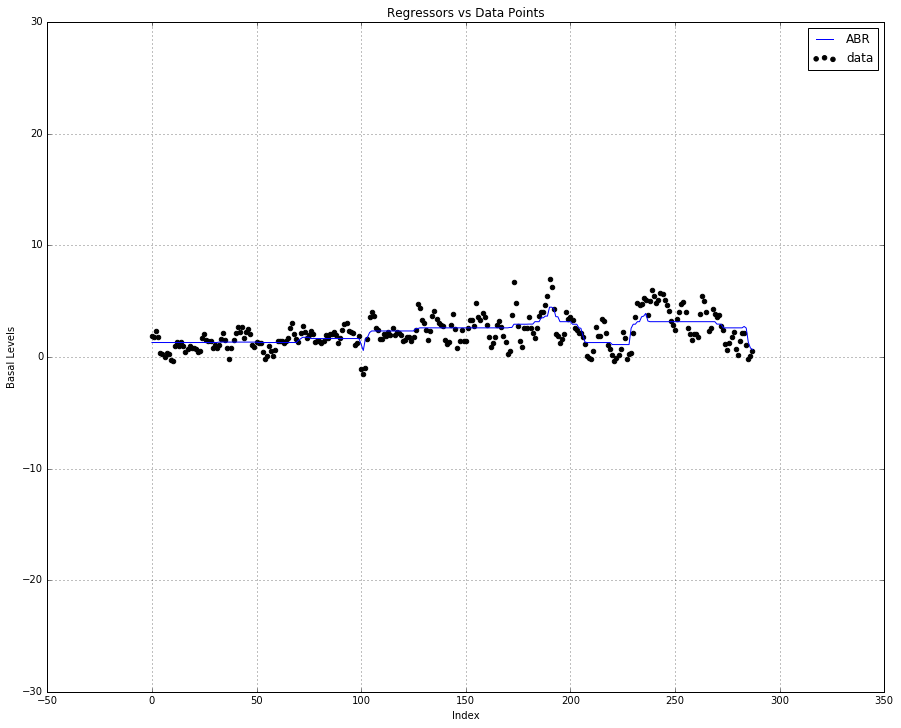

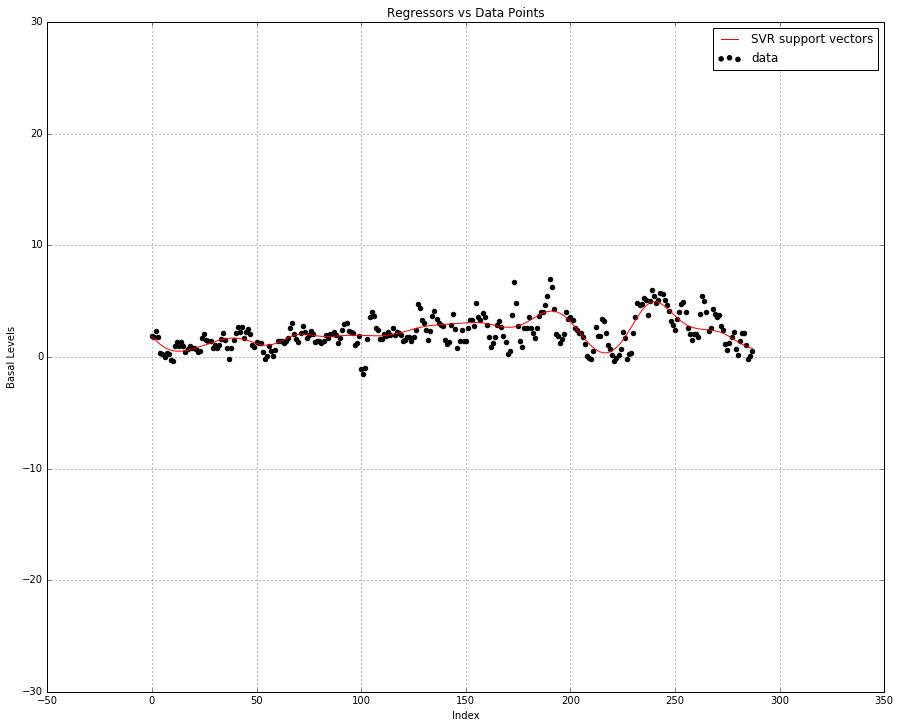

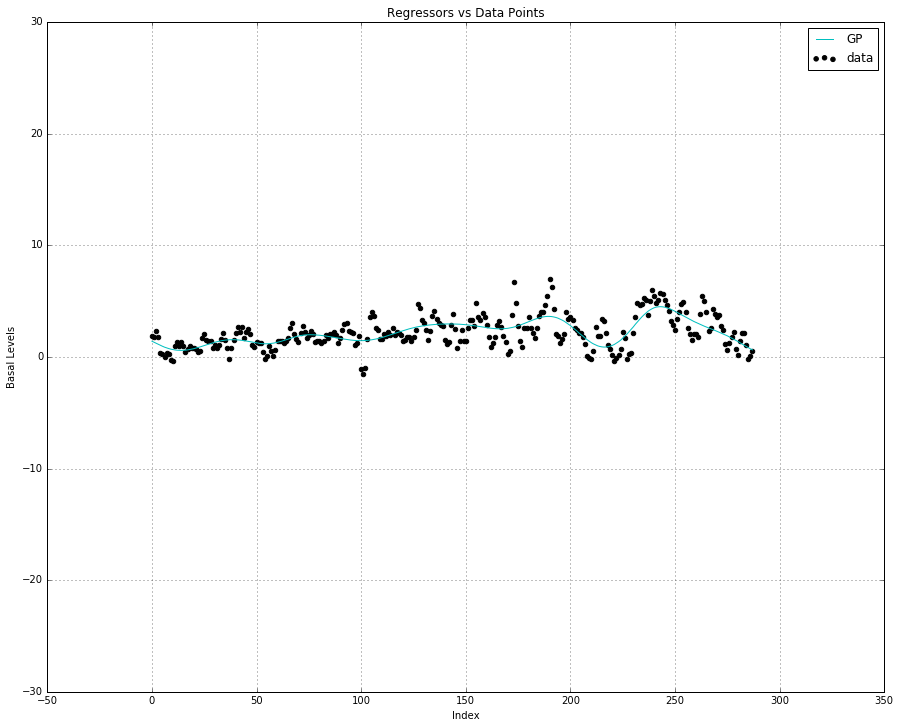

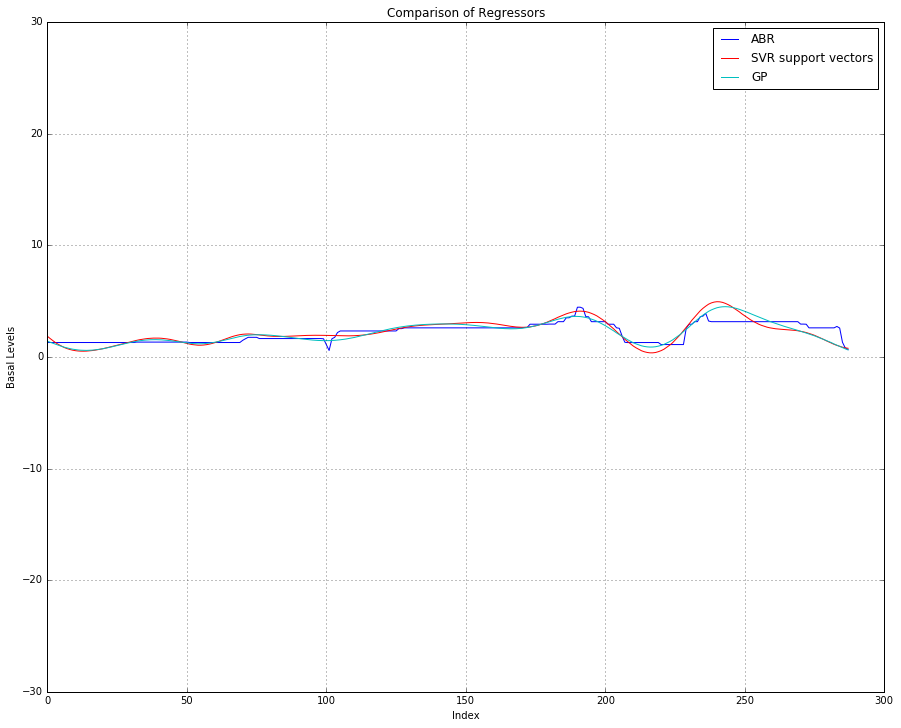

[1.4130008701542955, 1.3217729785840322, 1.2298888720292944, 1.1326797483119551, 1.0458703939454634, 0.96415771657616789, 0.88315199782145548, 0.81582446898953842, 0.75673898443534116, 0.70278811866785884, 0.66230221087261043, 0.63104362436392814, 0.60802304051230616, 0.59594409636007617, 0.59270479895994033, 0.59977437313311066, 0.61398443008242243, 0.63576468680129317, 0.66887234174627519, 0.70474466090885279, 0.74625952775633309, 0.7988958046480894, 0.84987723959016837, 0.90407218045956572, 0.96786200740578376, 1.0260249570440081, 1.0846947423975308, 1.1502297843836304, 1.2070875579286904, 1.2617889659240431, 1.3197845558220118, 1.3673755982260758, 1.4105670796315355, 1.453217713526155, 1.4853000010391542, 1.511511791258247, 1.533664154892743, 1.5466779796079462, 1.5533830520883711, 1.5535084320082193, 1.5472650986336629, 1.5353830743813832, 1.5158210104840655, 1.4935180153775325, 1.4672363365422729, 1.4337799987500057, 1.40141773197485, 1.3674149648206524, 1.3282226567593898, 1.293

In [26]:
import sklearn.learning_curve as curves
y_pred2 = clf_B.predict(X_all)
y_pred3 = clf_C.predict(X_all)
y_pred4 = clf_D.predict(X_all)

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred2, c='b', label='ABR', zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-30,30])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred3, c='r', label='SVR support vectors',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-30,30])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred4, c='c', label='GP',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-30,30])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

#plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred2, c='b', label='ABR', zorder=2)
plt.plot(x_scat, y_pred3, c='r', label='SVR support vectors',zorder=2)
plt.plot(x_scat, y_pred4, c='c', label='GP',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Comparison of Regressors')
plt.ylim([-30,30])
plt.grid(True)
plt.legend()
plt.show()


# Choosing the Best Model
In this final section, you will choose from the three supervised learning models the best model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F1 score.

## Question 3 - Choosing the Best Model
Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?

In [ ]:
# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(n_readings)

plt.plot(x_scat, diabetes_data['Basal Carbs (Liver)'], c='k', label='data', zorder=1)
plt.axvline(x=288)
plt.axvline(x=576)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.axis([0, len(x_scat), -20, 30])
plt.title('Data Points')
plt.grid(True)
plt.legend()

## Question 4 - Model in Layman's Terms
In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.

## Implementation: Model Tuning
Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:

In [ ]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

# Create the parameters list you wish to tune
n_estimators_range = range(375,450,25) 
lr_range = [0.2, 0.5, 1.0, 1.5, 2.0]
loss_range =  ['linear', 'square', 'exponential']
param_grid = dict(n_estimators=n_estimators_range, learning_rate=lr_range, loss=loss_range)

# TODO: Initialize the classifier
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=0)

# TODO: Make an f1 scoring function using 'make_scorer' 
r2_scorer = make_scorer(r2_score)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=param_grid, scoring=r2_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final R2 score for training and testing after parameter tuning
print "Tuned model has a training R2 score of {:.4f}.".format(predict_BG(clf, X_train, y_train))
print "Tuned model has a testing R2 score of {:.4f}.".format(predict_BG(clf, X_test, y_test))

## Question 5 - Final Scores
What is the final model's F1 score for training and testing? How does that score compare to the untuned model?

Answer: Tuned model has a testing F1 score of 0.8591. This is about 1% pecentage point higher than the default SVM. It is also 4.75% pecentage points higher than the AdaBoost.

It is worth noting that I used the StratifiedShuffleSplit cross-validation generator. This was done because we are dealing with an unbalanced dataset. Our target row has 67% of students passing and 33% failing. Therefore the StratisfiedShuffleSplit was used because it creates splits by preserving the same percentage for each target class as in the complete set. - See ref: http://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from basal import Basal 
from bolusTime import bolusTime
from carbCurve import Carbs
from carbCurveTime import CarbTIME

L = n_readings         # Length of Dataset
ISF = -37.7142857143   # Insulin Sensitivity Factor - How much one unit of insulin
                       # decreases BG (negative because it decreases BG)
C2R = 3.0              # How much 1 gram of Carbs raises BG level

# 1 - Bolus
basal, bolus = Basal(1,49) # creates curb for bolus ingestion
Bolus = bolusTime(bolus, 0, 1, L)

# 2 - CARBS
carb = Carbs(0.4, 0.0, L) # carb is calculated for an entire length of L
CarbsT = CarbTIME(carb, 3, 1)

#<---------- 
# Analysis: Part 3 - Calculate BG 
#<----------

CValue = 76.0  # Initialize a value for BG

################
# NEEDS UPDATE

def create_BG(CValue, diabetes_data, L, bolus, carb):
    # Create array for all the boluses that take place
    TB = [] # Total boluses combined from ingestion
    x = 0
    for x in range(L):
        TB.append(bolusTime(bolus, x, diabetes_data["Bolus Taken"][x], L))
        x += 1 
    TB = np.array(TB)
    TB = sum(TB)
    
    # Create array for all the Carbs that take place
    TC = []
    for x in range(L):
        TC.append((CarbTIME(carb, x, diabetes_data["Carbs Eaten"][x])))
        x += 1
    TC = np.array(TC)
    TC = sum(TC)
    
    # Create array for BG - Target!
    DFL = np.array(diabetes_data["Basal Carbs (Liver)"])
    DFB = np.array(diabetes_data["Basal Insulin"])
    DFB = DFB * -1       # Values decrease blood glucose
    DFL = DFL * C2R
    TC      = TC * C2R
    TB      = TB * ISF
    
    BG = [0.0]*L
    BG.insert(0,CValue)
    
    for x in range(1, L):
        BG[x] = BG[x-1] + DFL[x] + DFB[x] + TC[x] + TB[x]
        
    del BG[-1]
    
    return BG

#BG = create_BG(CValue, diabetes_data, L, bolus, carb)
#diabetes_data['BG'] = BG
#print BG